In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn import preprocessing

df = pd.read_csv("cereal_cleaned.csv")

In [2]:
df.head()

,Unnamed: 0,name,manufacturer,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
0,0,100% Bran,Nabisco,Cold,70,4,1,130,10.0,5.0,6.0,280.0,25,3,1.0,0.33,68.402973
1,1,100% Natural Bran,Quaker,Cold,120,3,5,15,2.0,8.0,8.0,135.0,0,3,1.0,1.00,33.983679
2,2,All-Bran,Kellogs,Cold,70,4,1,260,9.0,7.0,5.0,320.0,25,3,1.0,0.33,59.425505
3,3,All-Bran with Extra Fiber,Kellogs,Cold,50,4,0,140,14.0,8.0,0.0,330.0,25,3,1.0,0.50,93.704912
4,4,Almond Delight,Ralston Purina,Cold,110,2,2,200,1.0,14.0,8.0,NaN,25,3,1.0,0.75,34.384843


In [3]:
df= df.dropna()

## Feature Selection

We removed "manufacturer" because we were more interested in the components of the cereal rather than the brand of the cereal. We also removed "type" because there are only three hot cereals in our dataset.

In [4]:
df_X = df[["calories", "protein", "fat", "sodium", "fiber", "carbo", "sugars", "potass", "vitamins"]]
df_y = df["rating"]

Normalize the data

In [5]:
min_max_scaler = preprocessing.MinMaxScaler()
norm_X = pd.DataFrame(min_max_scaler.fit_transform(df_X.values), columns = df_X.columns)

Our correlation heatmap shows that potassium is highly correlated with fiber (0.9) so we removed the potassium feature

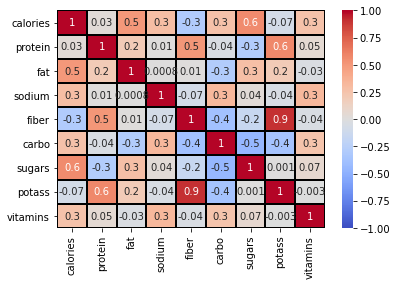

In [6]:
sns.heatmap(norm_X.corr(), annot = True, fmt='.1g', vmin=-1, vmax=1, center= 0, 
            cmap= 'coolwarm', linewidths=1, linecolor='black')

In [7]:
norm_X.drop("potass", axis=1, inplace = True)

Here we use RFE (Recursive Feature Elimination) for selecting features. RFE removes attributes and builds the regression to rank features. The output are the features rankings.

In [8]:
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 1)
#Transforming data using RFE
X_rfe = rfe.fit_transform(norm_X,df_y)  
#Fitting the data to model
model.fit(X_rfe,df_y)
print(rfe.ranking_)

[1 5 7 4 2 3 6 8]


Below we used these ranked features and and create models with one feature and the way to eight features. Each model is scored the highest score tells us the number of features we should move forward with.

In [9]:
# number of features that we are choosing from
nof_list=np.arange(1,8)   
# variable to store the high score
high_score=0

# variable to store the optimum features
nof=0           
score_list =[]

# loop through 
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(norm_X,df_y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 7
Score with 7 features: 0.989774


Because 7 features are shown as optimum we can remove the worst performing feature which was vitamins.

In [10]:
norm_X.drop("vitamins", axis=1, inplace = True)

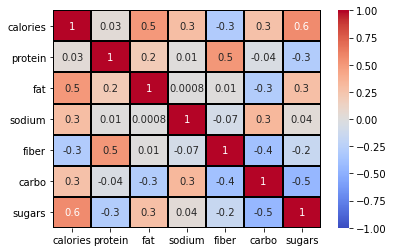

In [11]:
sns.heatmap(norm_X.corr(), annot = True, fmt='.1g', vmin=-1, vmax=1, center= 0, 
            cmap= 'coolwarm', linewidths=1, linecolor='black')

## Pair Grid

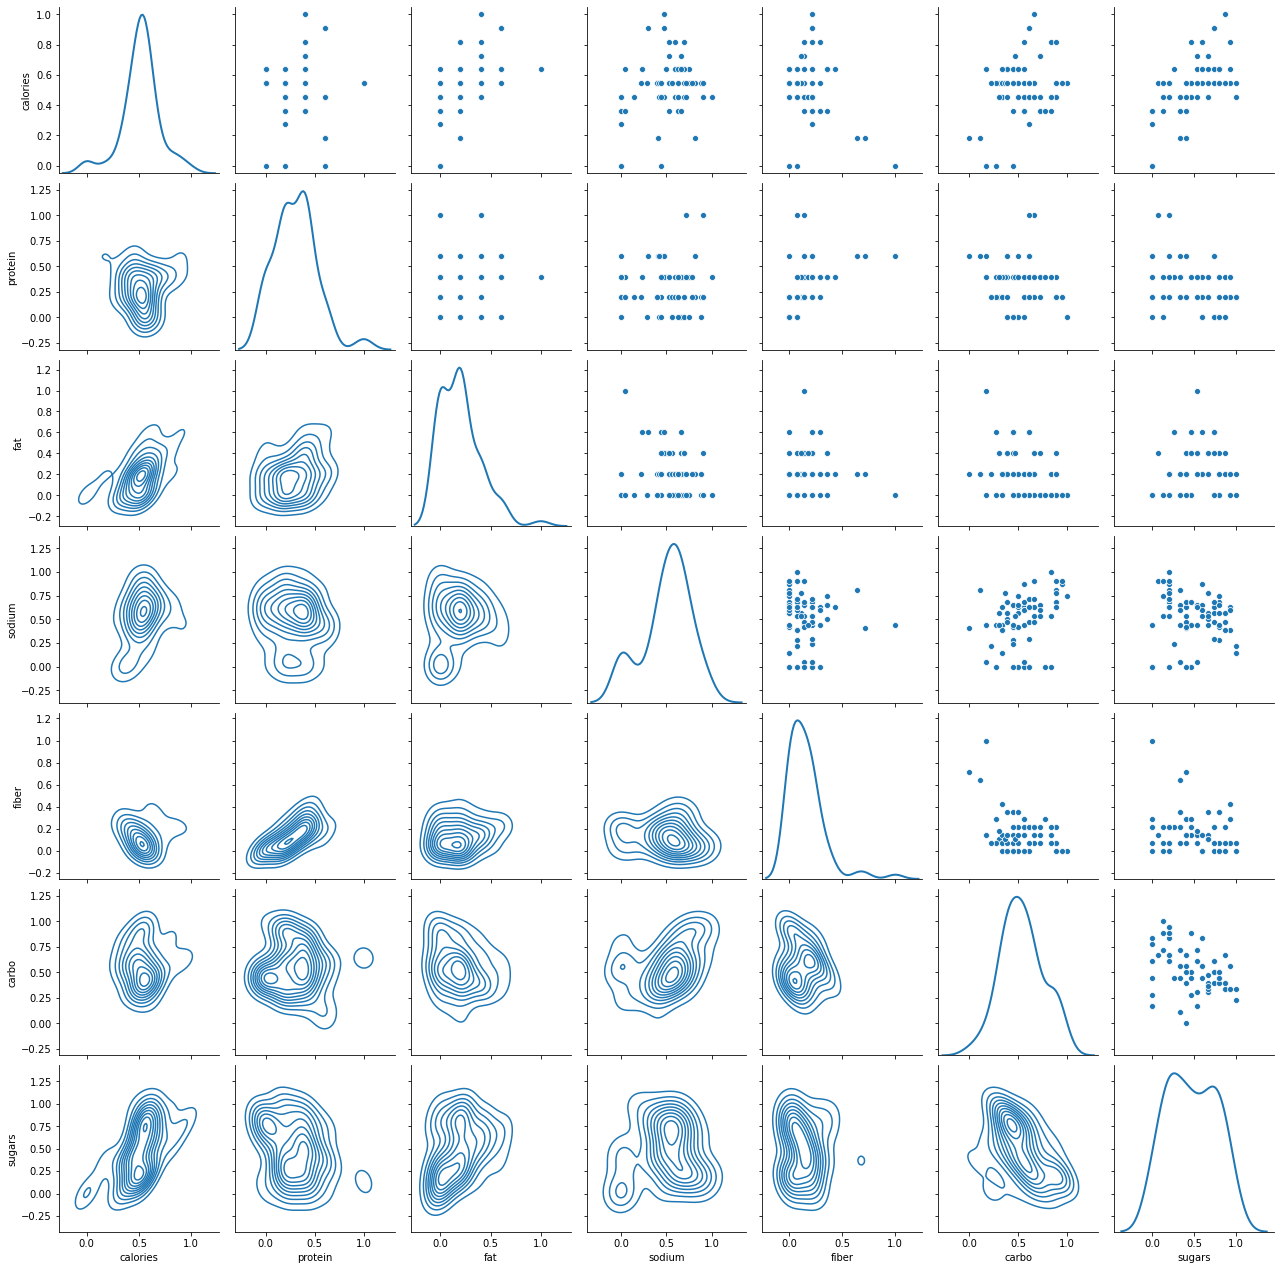

In [12]:
g = sns.PairGrid(norm_X, diag_sharey=False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot, colors="C0")
g.map_diag(sns.kdeplot, lw=2)

Distribution of ratings

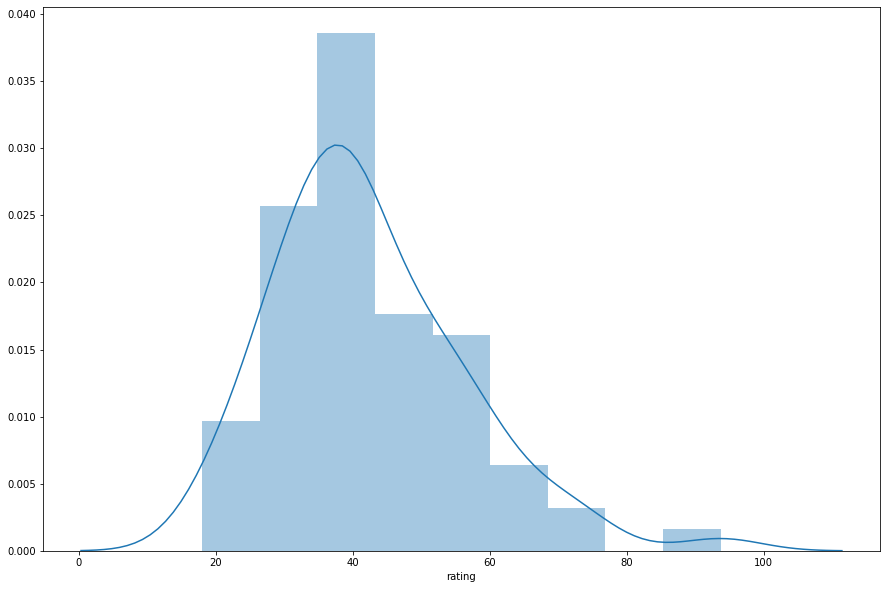

In [13]:
plt.figure(figsize=(15,10))
plt.tight_layout()
sns.distplot(df_y)

## Linear Regression

We will be performing linear regression on our selected variable to determine which features have the most impact to the cereals ratings.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(norm_X,df_y, test_size = 0.3, random_state = 0)

regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [15]:
from sklearn import metrics
y_pred = regressor.predict(X_test)

This model has a very high R-squared so the model accurately explains the variation in rating

In [16]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.9897744614968232

In [17]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1.0047905961895693
Mean Squared Error: 1.6773176179583091
Root Mean Squared Error: 1.2951129749787502


In [18]:
coeff_df = pd.DataFrame(regressor.coef_, norm_X.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
calories,-20.136033
protein,13.276032
fat,-11.930712
sodium,-17.760929
fiber,33.858466
carbo,12.840273
sugars,-16.953433


This shows that calories, fat, sodium, and sugar had a negative impact to rating while carbs, fiber, and protein had a positive impact to rating.